In [12]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
!ls data

PF-example-data.txt


In [3]:
# data url: http://daweb.ism.ac.jp/yosoku/

# 直接読み込む場合 
#df = pd.read_csv("http://daweb.ism.ac.jp/yosoku/materials/PF-example-data.txt", header=-1)

# 別途ダウンロードしてから取り込む場合
df = pd.read_csv("./data/PF-example-data.txt", header=-1)

df.columns = ["data"]

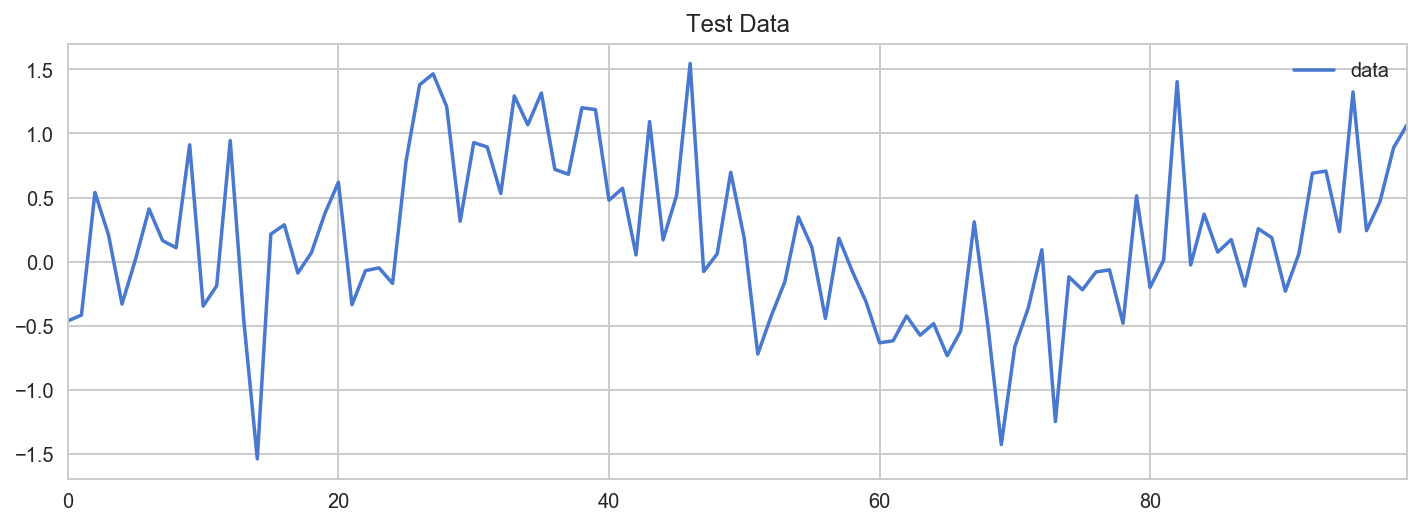

In [13]:
df.plot(figsize=(12,4))
plt.title("Test Data")

In [5]:
class ParticleFilter(object):
    def __init__(self, y, n_particle, sigma_2, alpha_2):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf
    
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1

    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle))
        x_resampled = np.zeros((T+1, self.n_particle))
        
        # 潜在変数の初期値
        initial_x = rd.normal(0, 1, size=self.n_particle)
        x_resampled[0] = initial_x
        x[0] = initial_x

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                x[t+1, i] = x_resampled[t, i] + v # システムノイズの付加
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i], self.sigma_2) # y[t]に対する各粒子の尤度
                w_normed[t] = w[t]/np.sum(w[t]) # 規格化
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            x_resampled[t+1] = x[t+1, k]
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def draw_glaph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y)
        plt.plot(np.mean(self.x, axis=1)[1:], "g")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color="r", s=2, alpha=0.1)

        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2, 
                                                                                 self.alpha_2, 
                                                                                 self.log_likelihood))
        #plt.show()

### パーティクルフィルターによるフィルタリング

In [6]:
# ハイパーパラメーター、
a = -2
b = -1

n_particle = 10**4*2
sigma_2 = 2**a
alpha_2 = 10**b

In [7]:
pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)

In [8]:
pf.simulate()

 calculating... t=99

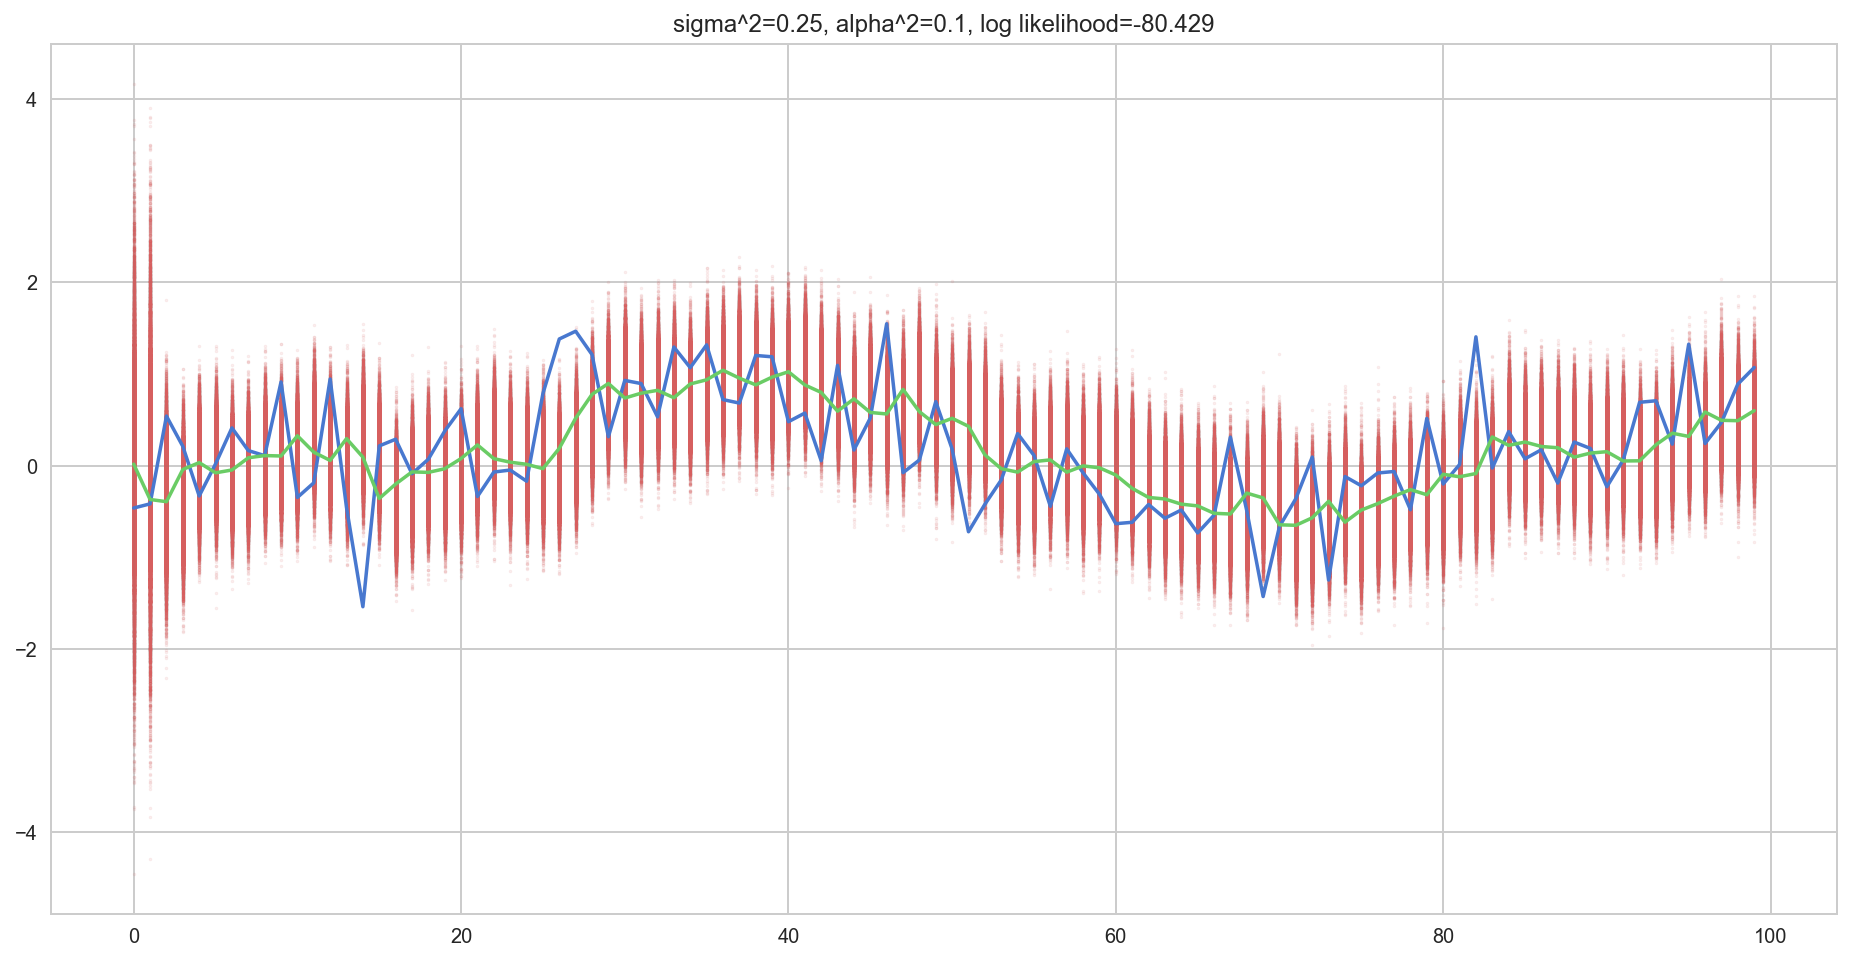

In [14]:
pf.draw_glaph()

### カルマンフィルターと見比べる

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                 -78.631
Date:                Sun, 11 Jun 2017   AIC                            161.261
Time:                        15:56:03   BIC                            166.472
Sample:                             0   HQIC                           163.370
                                - 100                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.2062      0.039      5.235      0.000       0.129       0.283
sigma2.level         0.0216      0.012      1.802      0.072      -0.002       0.045
Ljung-Box (Q):              

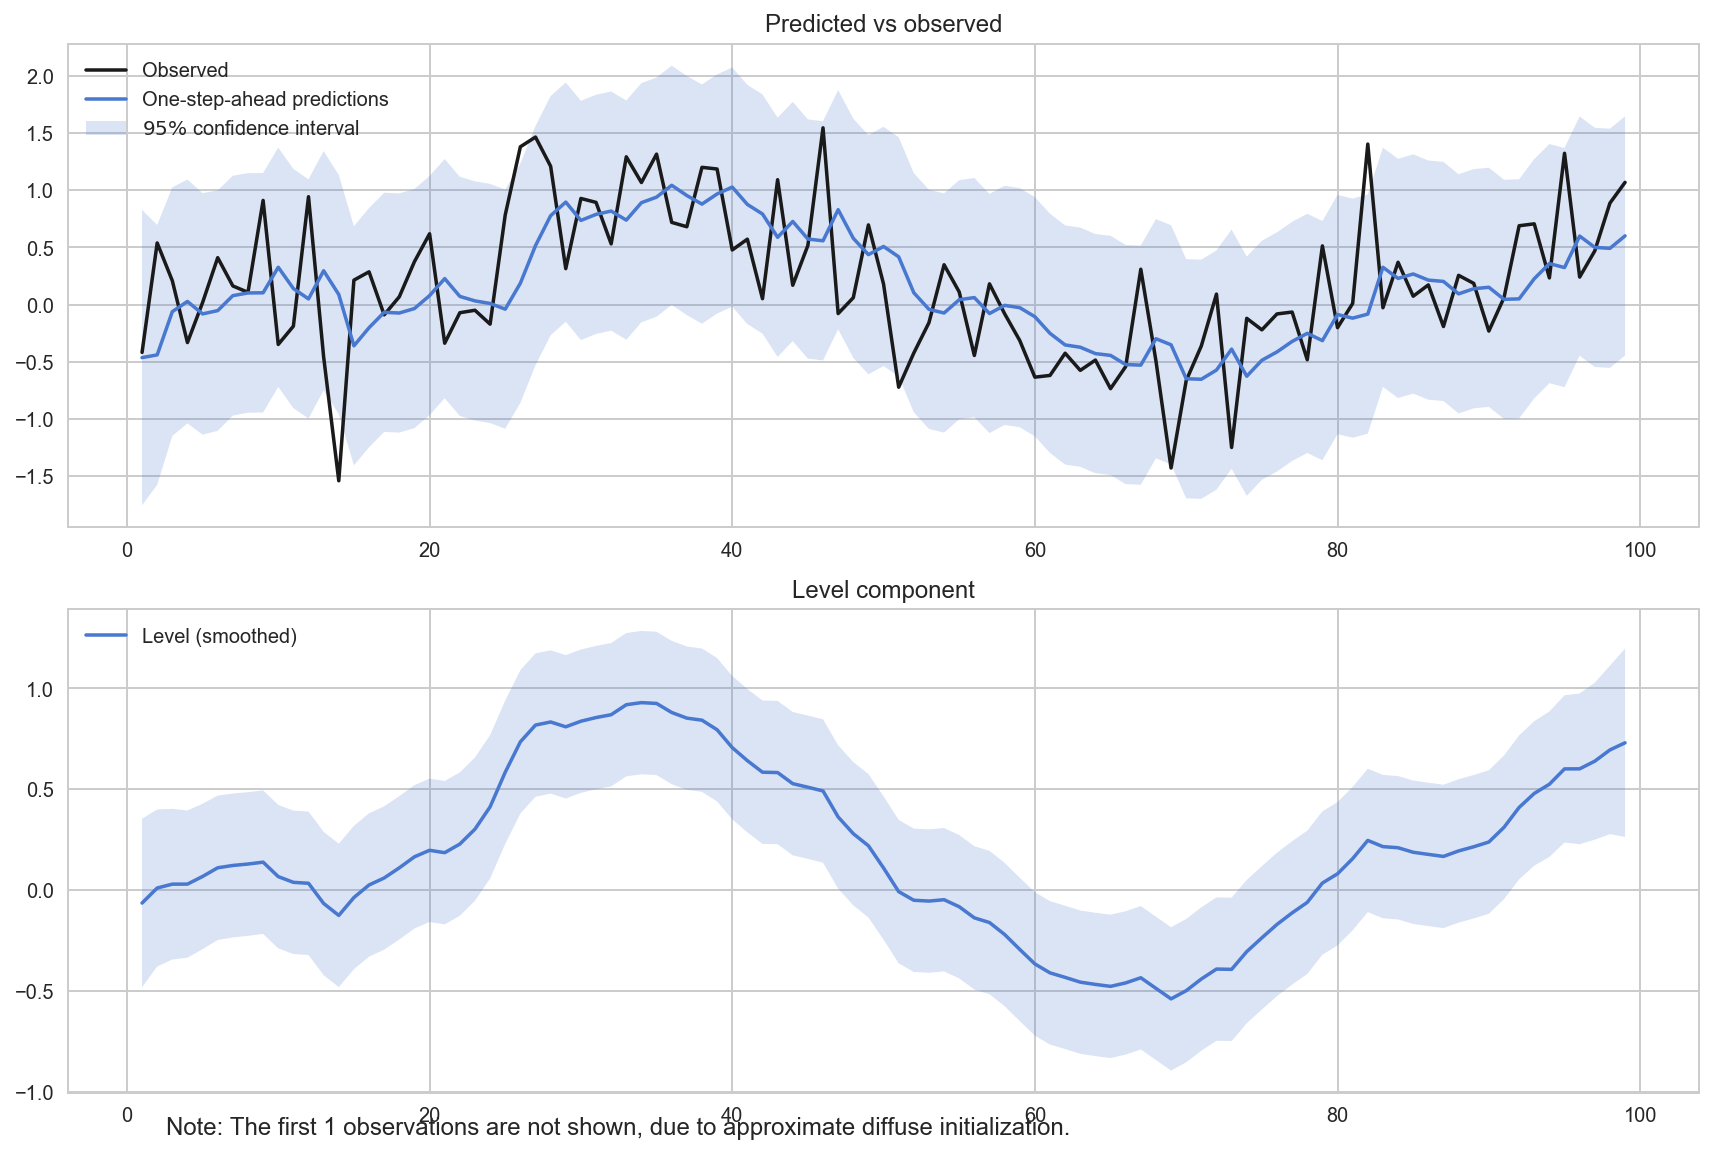

In [23]:
# Unobserved Components Modeling (via Kalman Filter)の実行
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(df.data.values, 'local level')
res_ll = mod_ll.fit()

print(res_ll.summary())

# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components(legend_loc="upper left", figsize=(12,8))
plt.tight_layout()

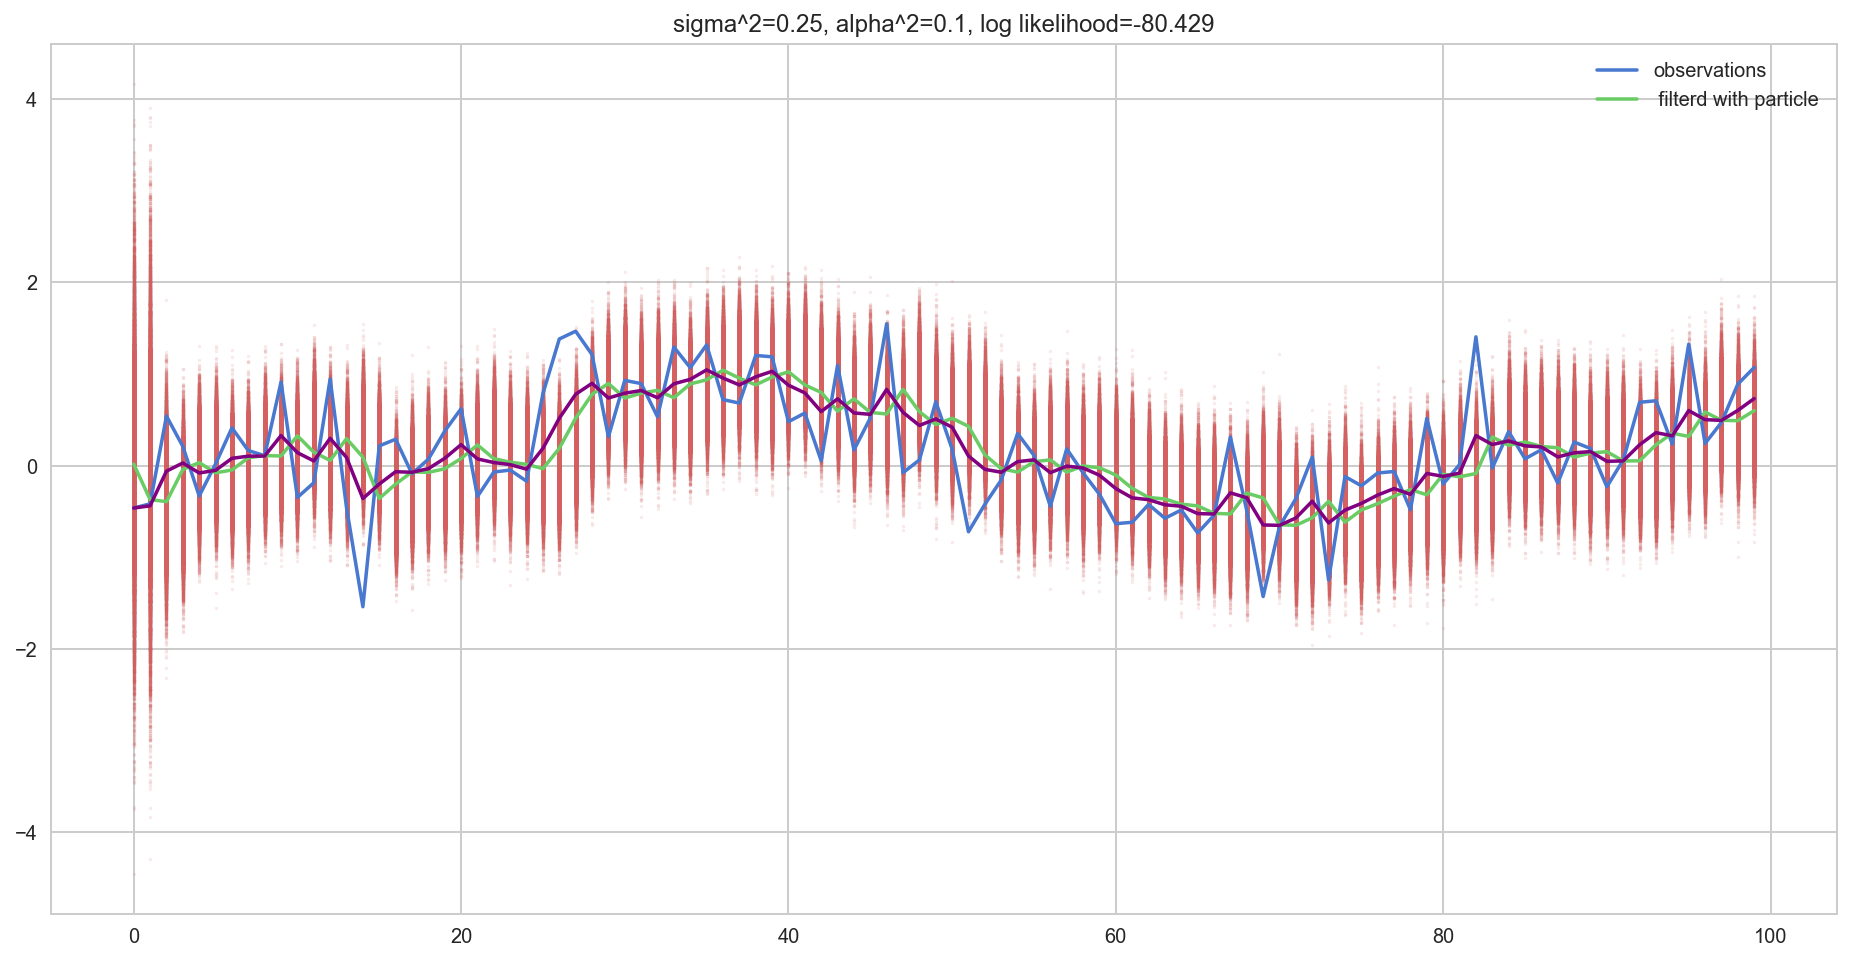

In [42]:
T = len(pf.y)

plt.figure(figsize=(16,8))
plt.plot(range(T), pf.y, label="observations")
plt.plot(np.mean(pf.x, axis=1)[1:], "g" ,label=" filterd with particle")
for t in range(T):
    plt.scatter(np.ones(pf.n_particle)*t, pf.x[t], color="r", s=2, alpha=0.1)
plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(pf.sigma_2, 
                                                                    pf.alpha_2, 
                                                                    pf.log_likelihood))

plt.plot(res_ll.filtered_state.reshape(res_ll.filtered_state.shape[1]), "purple", label="UCM filtered")
plt.legend(loc="best")
plt.show()

### ハイパーパラメータGrid Search

In [38]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)

 calculating... t=99
-8 -5 -8019.33258929
 calculating... t=99
-8 -4 -7425.61017451
 calculating... t=99
-8 -3 -6941.00704273
 calculating... t=99
-8 -2 -5362.01058711
 calculating... t=99
-8 -1 -3551.54771092
 calculating... t=99
-8 0 -2091.05643101
 calculating... t=99
-8 1 -662.374644368
 calculating... t=99
-8 2 -103.131463682
 calculating... t=99
-8 3 -167.043037174
 calculating... t=99
-8 4 -282.412309182
 calculating... t=99
-8 5 -402.08425577
 calculating... t=99
-7 -5 -3533.28743434
 calculating... t=99
-7 -4 -3625.80885511
 calculating... t=99
-7 -3 -3183.40942605
 calculating... t=99
-7 -2 -2425.64533519
 calculating... t=99
-7 -1 -1491.72612539
 calculating... t=99
-7 0 -886.673209565
 calculating... t=99
-7 1 -235.823142464
 calculating... t=99
-7 2 -106.115309836
 calculating... t=99
-7 3 -201.159042464
 calculating... t=99
-7 4 -321.345522475
 calculating... t=99
-7 5 -436.483596862
 calculating... t=99
-6 -5 -1514.58935613
 calculating... t=99
-6 -4 -1493.77125664
 calc

In [45]:
idx = np.argmax(likelihood_list)
print("argmax idx:", idx)

print("likelihood={}, a:{}, b={}".format(likelihood_list[idx], a_list[idx], b_list[idx]))

argmax idx: 70
likelihood=-79.82891663135456, a:-2, b=-1
